In [ ]:
pip install torch matplotlib pandas transformers sacrebleu bert-score evaluate

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BartForConditionalGeneration, BartTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer
import sacrebleu
from bert_score import score
import PerspectiveDataset as prep  # Your preprocessing module
from evaluate import load

Original dataset size: 2236
Expanded dataset size (with all perspectives): 4368

Sample 1:
Input: Summarize the following content according to Perspective: INFORMATION_SUMMARY; INFORMATION_SUMMARY Definition: Defined as knowledge about diseases, disorders, and health-related facts, providing insights into symptoms and diagnosis.; Begin Summary with: For information purposes...; Tone of summary: Informative, Educational.; Content to summarize: u spelt it wrong !! Parkinson's disease is one of the most common neurologic disorders of the elderly. The term "parkinsonism" refers to any condition that causes any combination of the types of movement abnormalities seen in Parkinson's disease by damaging or destroying dopamine neurons in a certain area of the brain. Parkinsonism describes the common symptoms of Parkinson's disease - tremor, rigidity, akinesia or bradykinesia and postural instability. Those patients who respond to drug treatment for Parkinson's disease are diagnosed with it, and

/raid/home/ganeshb/private/PerspectiveDataset.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = {key: torch.tensor(val).squeeze(0) for key, val in input.items()}
/raid/home/ganeshb/.venv/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_3861036/3327230077.py:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/raid/home/ganeshb/private/PerspectiveDataset.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

Step,Training Loss,Validation Loss,Bleu,Bertscore F1
500,1.239500,0.862783,0.799692,0.872750
1000,0.783800,0.837352,0.943201,0.873982
1500,0.619100,0.829988,0.916774,0.877252
2000,0.481400,0.860357,1.034660,0.876177
2500,0.361800,0.897275,0.959069,0.877153
3000,0.278300,0.928506,0.991575,0.876553


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/raid/home/ganeshb/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:2810: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/raid/home/ganeshb/private/PerspectiveDataset.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = {key: torch.tensor(val).squeez

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test set evaluation:
eval_loss: 0.9273
eval_bleu: 0.9636
eval_bertscore_f1: 0.8760
eval_runtime: 89.9525
eval_samples_per_second: 13.9180
eval_steps_per_second: 3.4800
epoch: 6.0000


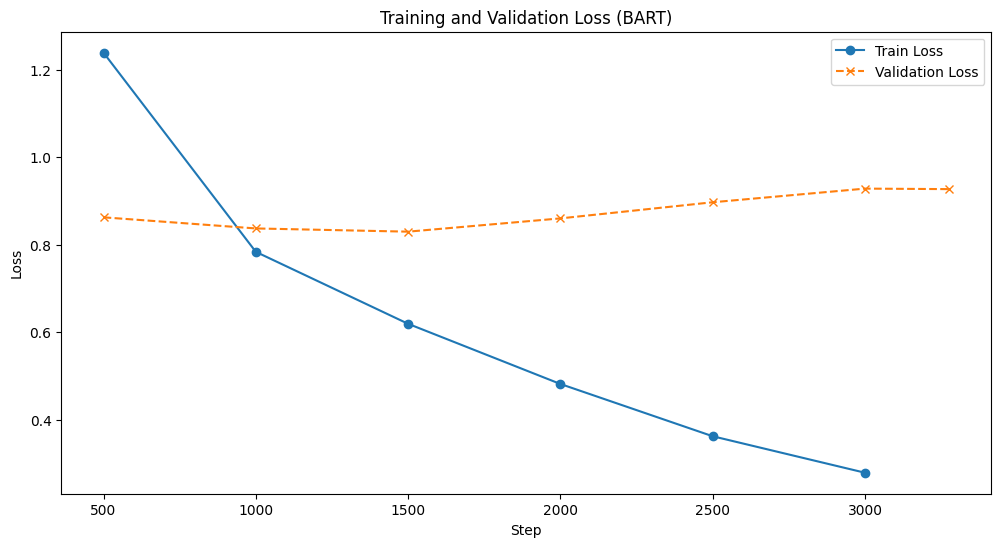

/raid/home/ganeshb/private/PerspectiveDataset.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = {key: torch.tensor(val).squeeze(0) for key, val in input.items()}
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics on the whole test dataset:
test_loss: 0.9273
test_bleu: 0.9636
test_bertscore_f1: 0.8760
test_runtime: 88.6975
test_samples_per_second: 14.1150
test_steps_per_second: 3.5290


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BartForConditionalGeneration, BartTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer
import sacrebleu
from bert_score import score
import PerspectiveDataset as prep
from evaluate import load

# Set CUDA device if available
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

###################### Helper Functions ###########################
def filter_invalid_tokens(seq):
    """Remove tokens with value -100."""
    return [token for token in seq if token != -100]


def remove_empty_predictions(predictions, references):
    """Remove any empty predictions or labels to avoid warnings with BERTScore."""
    filtered_data = [(p, r) for p, r in zip(predictions, references) if p and r]
    if not filtered_data:
        return []
    return filtered_data


def compute_bleu_score(predictions, references):
    """Compute the SacreBLEU score."""
    bleu_metric = load("sacrebleu")
    return bleu_metric.compute(predictions=predictions, references=references)["score"]


def compute_bertscore_f1(predictions, references):
    """Compute the BERTScore F1."""
    P, R, f1_scores = score(predictions, references, lang="en", verbose=False)
    return P.mean().item(), R.mean().item(), f1_scores.mean().item()


def plot(trainer):
    """Plot training and validation loss curves."""
    logs_df = pd.DataFrame(trainer.state.log_history)

    train_logs = logs_df[logs_df['loss'].notnull()]
    plt.plot(train_logs['step'], train_logs['loss'], label="Train Loss", marker='o', linestyle='-')

    eval_logs = logs_df[logs_df['eval_loss'].notnull()]
    plt.plot(eval_logs['step'], eval_logs['eval_loss'], label="Validation Loss", marker='x', linestyle='--')

    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss (BART)")
    plt.legend()
    plt.savefig("bart_training_validation_loss.png")
    plt.show()


##################### Main Model Class #################
class Model:
    def __init__(self, model_name):
        self.trainer = None
        self.train_ds = None
        self.valid_ds = None
        self.test_ds = None
        self.model_name = model_name
        self.seq2seq_model = BartForConditionalGeneration.from_pretrained(model_name)
        self.seq2seq_tokenizer = BartTokenizer.from_pretrained(model_name)

    def initialize_model_dataset(self):
        """Initialize datasets."""
        self.train_ds = prep.PerspectiveDataset(prep.train_data, self.seq2seq_tokenizer)
        self.valid_ds = prep.PerspectiveDataset(prep.val_data, self.seq2seq_tokenizer)
        self.test_ds = prep.PerspectiveDataset(prep.test_data, self.seq2seq_tokenizer)

    def compute_metrics(self, eval_pred):
        """Compute BLEU and BERTScore metrics."""
        preds, targets = eval_pred

        # Filter out invalid tokens
        preds = [filter_invalid_tokens(seq) for seq in preds]
        targets = [filter_invalid_tokens(seq) for seq in targets]

        decoded_preds = [self.seq2seq_tokenizer.decode(seq, skip_special_tokens=True).strip().lower() for seq in preds]
        decoded_targets = [self.seq2seq_tokenizer.decode(seq, skip_special_tokens=True).strip().lower() for seq in targets]

        is_empty = remove_empty_predictions(decoded_preds, decoded_targets)
        if not is_empty:
            return {"bleu": 0.0, "bertscore_f1": 0.0, "bertscore_Recall": 0.0, "bertscore_precision": 0.0}
        
        decoded_preds, decoded_targets = zip(*is_empty)

        bleu_result = compute_bleu_score(decoded_preds, decoded_targets)
        bert_P, bert_R, bert_f1 = compute_bertscore_f1(decoded_preds, decoded_targets)

        return {
            "bleu": bleu_result,
            "bertscore_f1": bert_f1,
            "bertscore_Recall": bert_R,
            "bertscore_precision": bert_P
        }

    def evaluate_on_test(self):
        """Evaluate on test dataset."""
        test_results = self.trainer.evaluate(self.test_ds)
        print("Test set evaluation:")
        for metric, value in test_results.items():
            print(f"{metric}: {value:.4f}")

    def fit(self):
        """Train and evaluate the model."""
        training_args = Seq2SeqTrainingArguments(
            output_dir="./bart-healthcare-summaries_final",
            evaluation_strategy="steps",
            save_strategy="epoch",
            learning_rate=3e-4,
            logging_steps=500,
            per_device_train_batch_size=4,
            per_device_eval_batch_size=4,
            save_total_limit=2,
            num_train_epochs=6,
            gradient_accumulation_steps=2,
            predict_with_generate=True,
            fp16=False,
            logging_dir="./logs",
            report_to="none",
        )

        self.trainer = Seq2SeqTrainer(
            model=self.seq2seq_model,
            args=training_args,
            train_dataset=self.train_ds,
            eval_dataset=self.valid_ds,
            tokenizer=self.seq2seq_tokenizer,
            compute_metrics=self.compute_metrics
        )

        self.trainer.train()
        self.trainer.evaluate(self.test_ds)
        plot(self.trainer)

        save_directory = "../bart-model_checkpoint"
        self.seq2seq_model.save_pretrained(save_directory)
        self.seq2seq_tokenizer.save_pretrained(save_directory)

        predictions_output = self.trainer.predict(self.test_ds)
        metrics = predictions_output.metrics

        print("Metrics on the whole test dataset:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")


# Initialize and train the model
model_name = "facebook/bart-base"
model = Model(model_name)
model.initialize_model_dataset()
model.fit()


In [ ]:
import torch
from transformers import BartForConditionalGeneration, BartTokenizer
import PerspectiveDataset as prep  # Your preprocessing module

# Specifying the checkpoint directory (same as output_dir used during training for BART)
checkpoint_path = "../bart-model_checkpoint"

# Loading the saved model checkpoint and tokenizer
model = BartForConditionalGeneration.from_pretrained(checkpoint_path)
tokenizer = BartTokenizer.from_pretrained(checkpoint_path)

# Creating the test dataset instance using the full test data or a subset (here using first 100 entries)
test_dataset = prep.PerspectiveDataset(prep.test_data[:100], tokenizer)

# Setting device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

# Generate predictions for the first 20 test entries and save them to a file
output_filename = "test_predictions_from_checkpoint_bart.txt"
with open(output_filename, "w", encoding="utf-8") as f:
    for i in range(20):
        # Get the i-th sample from the test dataset
        sample = test_dataset[i]
        # Ensure input is on the proper device and add batch dimension
        input_ids = sample["input_ids"].unsqueeze(0).to(device)
        # Generate prediction (adjust max_length if needed)
        generated_ids = model.generate(input_ids, max_length=512)
        pred_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        
        f.write(f"Entry {i+1}:\n")
        f.write(f"Sample {prep.test_data[i]} \n")
        f.write(f"Prediction: {pred_text}\n\n")

print(f"Predictions for first 20 test entries have been saved to '{output_filename}'.")


Predictions for first 20 test entries have been saved to 'test_predictions_from_checkpoint_bart.txt'.
